# Component 1: Streaming Service Customer Analytics (Regression, Churn, Clustering)

## Overview
This notebook applies supervised and unsupervised learning to a streaming service dataset. It focuses on predicting Monthly Spend, classifying churn, and segmenting customers into behavioural clusters.

## Objectives
- Compare single-feature regression models (linear vs polynomial) for Monthly Spend.
- Evaluate multi-feature regression and the impact of adding categorical features.
- Train and compare churn classification models using appropriate metrics.
- Apply clustering (k-Means and at least one alternative) to segment customers.

## Tools
- Python
- Pandas
- NumPy
- Scikit-learn
- Matplotlib
- Seaborn
- Jupyter Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score,
    confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from IPython.display import display

In [2]:
# Loading the dataset
df = pd.read_csv("Streaming.csv")

# prints the shape and missing values
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())

# defining the target variables and features
TARGET_REG = "Monthly_Spend" # Monthly_Spend is the regression target
TARGET_CLF = "Churned" # Churned is the classification target
RANDOM_STATE = 42

y_reg = df[TARGET_REG]
y_clf = df[TARGET_CLF]

# # X is all other features (everything except the targets)
X = df.drop(columns=[TARGET_REG, TARGET_CLF])

# Drop ID column if present
if "Customer_ID" in X.columns:
    X = X.drop(columns=["Customer_ID"])

Shape: (5000, 12)
Columns: ['Customer_ID', 'Age', 'Gender', 'Subscription_Length', 'Region', 'Payment_Method', 'Support_Tickets_Raised', 'Satisfaction_Score', 'Discount_Offered', 'Last_Activity', 'Monthly_Spend', 'Churned']

Missing values per column:
 Customer_ID                 0
Age                       500
Gender                      0
Subscription_Length         0
Region                      0
Payment_Method              0
Support_Tickets_Raised      0
Satisfaction_Score        500
Discount_Offered            0
Last_Activity               0
Monthly_Spend               0
Churned                     0
dtype: int64


In [3]:
# Spliting the numeric and categorical columns

# separate numeric and categorical columns because they require different preprocessing
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("\nNumeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['Age', 'Subscription_Length', 'Support_Tickets_Raised', 'Satisfaction_Score', 'Discount_Offered', 'Last_Activity']
Categorical: ['Gender', 'Region', 'Payment_Method']


In [4]:
# Preprocessing pipelines

# I handle missing values inside pipelines so I prevent data leakage.
# For numeric: median imputation + scaling
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# For categorical: most frequent imputation + one-hot encoding
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# This transformer applies only numeric preprocessing (for part b numeric-only models)
preprocess_all = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

preprocess_num_only = ColumnTransformer(transformers=[
    ("num", numeric_pipe, numeric_cols)
])


# RMSE function
# used RMSE by taking square root of mean_squared_error

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


(a) Single-feature results:


,feature,RMSE_linear,R2_linear,RMSE_poly,R2_poly,best_degree
3,Satisfaction_Score,6.487249,0.534467,6.486895,0.534518,2
1,Subscription_Length,8.051573,0.282882,8.062932,0.280858,4
4,Discount_Offered,9.293519,0.044591,9.293517,0.044591,2
2,Support_Tickets_Raised,9.423111,0.017760,9.429672,0.016392,2
0,Age,9.512193,-0.000899,9.535701,-0.005852,4
5,Last_Activity,9.512671,-0.000999,9.514966,-0.001483,4


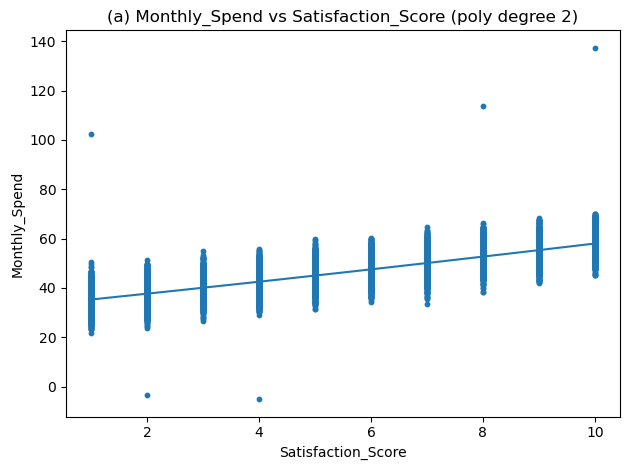

In [5]:
# Single numeric feature regression - linear vs polynomial

results_a = []

# loop through each numeric feature and train a linear and polynomial regression model
for feat in numeric_cols:
    X1 = df[[feat]]
    # I split into train and test.
    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, y_reg, test_size=0.2, random_state=RANDOM_STATE
    )

# Linear regression pipepline
    lin = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ])
    lin.fit(X1_train, y1_train)
    pred_lin = lin.predict(X1_test)

    rmse_lin = calc_rmse(y1_test, pred_lin)
    r2_lin = r2_score(y1_test, pred_lin)

# Polynomial model with tuned degree
    poly = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("model", LinearRegression())
    ])

    grid = GridSearchCV(
        poly,
        {"poly__degree": [2, 3, 4]},
        scoring="neg_root_mean_squared_error",
        cv=5
    )
    grid.fit(X1_train, y1_train)

    pred_poly = grid.best_estimator_.predict(X1_test)
    rmse_poly = calc_rmse(y1_test, pred_poly)
    r2_poly = r2_score(y1_test, pred_poly)
    best_degree = grid.best_params_["poly__degree"]

    results_a.append([feat, rmse_lin, r2_lin, rmse_poly, r2_poly, best_degree])
    
# converted the results to a DataFrame for easy comparison.
results_a_df = pd.DataFrame(
    results_a,
    columns=["feature", "RMSE_linear", "R2_linear", "RMSE_poly", "R2_poly", "best_degree"]
).sort_values("RMSE_linear")

print("\n(a) Single-feature results:")
display(results_a_df)

# plotted the best best feature relationship
best_feat = results_a_df.iloc[0]["feature"]
best_deg = int(results_a_df.iloc[0]["best_degree"])

poly_plot = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=best_deg, include_bias=False)),
    ("model", LinearRegression())
])
poly_plot.fit(df[[best_feat]], y_reg)

x_vals = np.linspace(df[best_feat].min(), df[best_feat].max(), 200)
x_plot = pd.DataFrame(x_vals, columns=[best_feat])   # <-- warning fixed
y_vals = poly_plot.predict(x_plot)

plt.figure()
plt.scatter(df[best_feat], y_reg, s=10)
plt.plot(x_vals, y_vals)
plt.title(f"(a) Monthly_Spend vs {best_feat} (poly degree {best_deg})")
plt.xlabel(best_feat)
plt.ylabel("Monthly_Spend")
plt.tight_layout()
plt.show()


(b) Numeric-only regression results (test set):


,model,RMSE,R2
1,Ridge(alpha=1.0),3.208406,0.886130
0,LinearRegression,3.208498,0.886124
2,GradientBoosting,3.297180,0.879742
3,RandomForest(n=300),3.450368,0.868308



(b) Numeric-only regression (5-fold CV):


,model,CV_RMSE_mean,CV_RMSE_std,CV_R2_mean,CV_R2_std
0,LinearRegression,3.127044,0.517179,0.890368,0.030986
1,Ridge(alpha=1.0),3.127045,0.517163,0.890368,0.030985
2,GradientBoosting,3.286995,0.436869,0.879613,0.027159
3,RandomForest(n=300),3.536952,0.499765,0.860137,0.035647


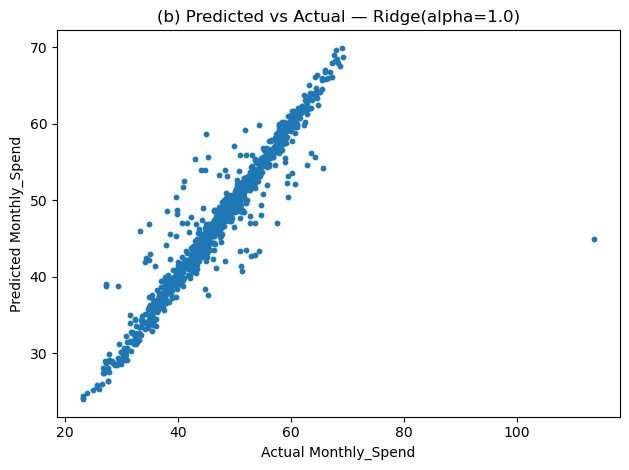

In [6]:
# Multi-feature regression (numeric only) + Cross validation

# I split the full dataset into train and test
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

# test multiple regression models using only numeric features.
reg_models_b = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "RandomForest(n=300)": RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300),
}

results_b = []
pred_store = {}

for name, model in reg_models_b.items():
    pipe = Pipeline(steps=[("prep", preprocess_num_only), ("model", model)])
    pipe.fit(Xr_train, yr_train)
    pred = pipe.predict(Xr_test)

    results_b.append([name, calc_rmse(yr_test, pred), r2_score(yr_test, pred)])
    pred_store[name] = pred

results_b_df = pd.DataFrame(results_b, columns=["model", "RMSE", "R2"]).sort_values("RMSE")
print("\n(b) Numeric-only regression results (test set):")
display(results_b_df)

# also used 5 fold Cross-validation for reliability
cv_rows = []
for name, model in reg_models_b.items():
    pipe = Pipeline(steps=[("prep", preprocess_num_only), ("model", model)])
    scores = cross_validate(
        pipe, X, y_reg, cv=5,
        scoring={"rmse": "neg_root_mean_squared_error", "r2": "r2"},
        n_jobs=-1
    )
    cv_rows.append([
        name,
        -scores["test_rmse"].mean(), scores["test_rmse"].std(),
        scores["test_r2"].mean(), scores["test_r2"].std()
    ])

cv_b_df = pd.DataFrame(
    cv_rows,
    columns=["model", "CV_RMSE_mean", "CV_RMSE_std", "CV_R2_mean", "CV_R2_std"]
).sort_values("CV_RMSE_mean")

print("\n(b) Numeric-only regression (5-fold CV):")
display(cv_b_df)

# ploting predicted vs Actual plot for best model
best_model_name = results_b_df.iloc[0]["model"]
best_pred = pred_store[best_model_name]

plt.figure()
plt.scatter(yr_test, best_pred, s=10)
plt.xlabel("Actual Monthly_Spend")
plt.ylabel("Predicted Monthly_Spend")
plt.title(f"(b) Predicted vs Actual — {best_model_name}")
plt.tight_layout()
plt.show()

In [7]:
# (c) Regression using numeric + categorical features + tuned RF

# Here I include categorical features using one-hot encoding in preprocess_all
reg_models_c = {
    "Ridge": Ridge(alpha=1.0),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=400),
}

results_c = []

# I train each model and evaluate on the test set
for name, model in reg_models_c.items():
    pipe = Pipeline(steps=[("prep", preprocess_all), ("model", model)])
    pipe.fit(Xr_train, yr_train)
    pred = pipe.predict(Xr_test)
    results_c.append([name, calc_rmse(yr_test, pred), r2_score(yr_test, pred)])

results_c_df = pd.DataFrame(results_c, columns=["model", "RMSE", "R2"]).sort_values("RMSE")
print("\n(c) Mixed-features regression (test set):")
print(results_c_df)

# tuned Random Forest hyperparameters to try to improve performance
rf_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_leaf": [1, 3, 5]
}

rf_tune_pipe = Pipeline(steps=[
    ("prep", preprocess_all),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_grid = GridSearchCV(
    rf_tune_pipe,
    rf_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

rf_grid.fit(Xr_train, yr_train)
best_rf = rf_grid.best_estimator_
pred_rf = best_rf.predict(Xr_test)

print("\n(c) Tuned Mixed-Features RandomForest (test set):")
print("Best params:", rf_grid.best_params_)
print("RMSE:", calc_rmse(yr_test, pred_rf))
print("R2:", r2_score(yr_test, pred_rf))


(c) Mixed-features regression (test set):
              model      RMSE        R2
0             Ridge  3.212570  0.885835
1  GradientBoosting  3.278768  0.881081
2      RandomForest  3.450894  0.868268

(c) Tuned Mixed-Features RandomForest (test set):
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__n_estimators': 300}
RMSE: 3.440907215848109
R2: 0.8690290899012343


In [8]:
# ANN regression model

# ANN needs numeric inputs, so I transform using preprocess_all first
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_reg, test_size=0.2, random_state=RANDOM_STATE
)

X_train_mat = preprocess_all.fit_transform(X_train_all)
X_test_mat = preprocess_all.transform(X_test_all)

# I use a simple ANN with two hidden layers, ReLU, Adam optimizer, and early stopping
ann = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=400,
    early_stopping=True,
    n_iter_no_change=15,
    random_state=RANDOM_STATE
)

ann.fit(X_train_mat, y_train_all)
pred_ann = ann.predict(X_test_mat)

print("\n(d) ANN (MLPRegressor) results:")
print("Iterations:", ann.n_iter_)
print("RMSE:", calc_rmse(y_test_all, pred_ann))
print("R2:", r2_score(y_test_all, pred_ann))


(d) ANN (MLPRegressor) results:
Iterations: 129
RMSE: 3.281508727361968
R2: 0.8808823687334819


In [9]:
# (e) Summary of best regression model

best_single = results_a_df.iloc[0]
best_b = results_b_df.iloc[0]
best_c = results_c_df.iloc[0]

# created a summary table to compare the best model from each section.
summary_e = pd.DataFrame([
    ["Best single-feature (linear)", best_single["feature"], best_single["RMSE_linear"], best_single["R2_linear"]],
    ["Best numeric-only multi-feature (test)", best_b["model"], best_b["RMSE"], best_b["R2"]],
    ["Best mixed-features baseline (test)", best_c["model"], best_c["RMSE"], best_c["R2"]],
    ["Tuned mixed-features RF (test)", "Tuned RandomForest", calc_rmse(yr_test, pred_rf), r2_score(yr_test, pred_rf)],
    ["ANN (MLPRegressor)", "MLP(64,32)", calc_rmse(y_test_all, pred_ann), r2_score(y_test_all, pred_ann)],
], columns=["candidate", "model_or_feature", "RMSE", "R2"]).sort_values("RMSE")

print("\n(e) Regression model summary:")
display (summary_e)


(e) Regression model summary:


,candidate,model_or_feature,RMSE,R2
1,Best numeric-only multi-feature (test),Ridge(alpha=1.0),3.208406,0.886130
2,Best mixed-features baseline (test),Ridge,3.212570,0.885835
4,ANN (MLPRegressor),"MLP(64,32)",3.281509,0.880882
3,Tuned mixed-features RF (test),Tuned RandomForest,3.440907,0.869029
0,Best single-feature (linear),Satisfaction_Score,6.487249,0.534467



(f) Classification comparison (test set):


,model,accuracy,precision,recall,f1,roc_auc
2,GradientBoosting,0.980,1.000000,0.955357,0.977169,0.995170
1,RandomForest,0.980,1.000000,0.955357,0.977169,0.988769
0,LogisticRegression,0.801,0.762105,0.808036,0.784399,0.892894



Best classifier: GradientBoosting AUC: 0.9951697560817805

Confusion matrix:
 [[552   0]
 [ 20 428]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       552
           1       1.00      0.96      0.98       448

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



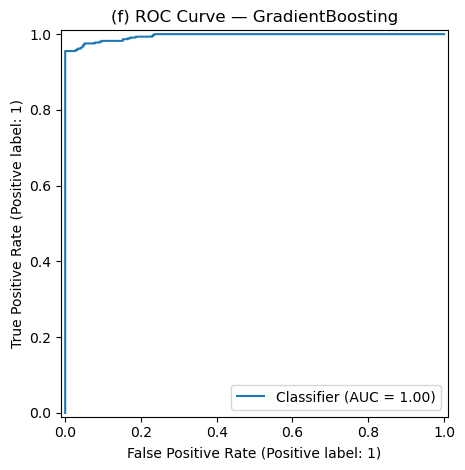

In [10]:
# Churn classification with full metrics + ROC curve

# I split data with stratification to keep churn distribution consistent
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)

clf_models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

clf_rows = []
best_auc = -1
best_name = None
best_pipe = None

# train each classifier and evaluate multiple metrics.
for name, clf in clf_models.items():
    pipe = Pipeline(steps=[("prep", preprocess_all), ("model", clf)])
    pipe.fit(Xc_train, yc_train)

    pred = pipe.predict(Xc_test)
    proba = pipe.predict_proba(Xc_test)[:, 1]
    auc = roc_auc_score(yc_test, proba)

    clf_rows.append([
        name,
        accuracy_score(yc_test, pred),
        precision_score(yc_test, pred, zero_division=0),
        recall_score(yc_test, pred, zero_division=0),
        f1_score(yc_test, pred, zero_division=0),
        auc
    ])
 # kept the track of the best model based on AUC
    if auc > best_auc:
        best_auc = auc
        best_name = name
        best_pipe = pipe

clf_df = pd.DataFrame(
    clf_rows,
    columns=["model", "accuracy", "precision", "recall", "f1", "roc_auc"]
).sort_values("roc_auc", ascending=False)

print("\n(f) Classification comparison (test set):")
display (clf_df)

best_pred = best_pipe.predict(Xc_test)
print("\nBest classifier:", best_name, "AUC:", best_auc)
print("\nConfusion matrix:\n", confusion_matrix(yc_test, best_pred))
print ("\nClassification report:\n", classification_report(yc_test, best_pred))

# I plot ROC curve for the best classifier
RocCurveDisplay.from_predictions(yc_test, best_pipe.predict_proba(Xc_test)[:, 1])
plt.title(f"(f) ROC Curve — {best_name}")
plt.tight_layout()
plt.show()

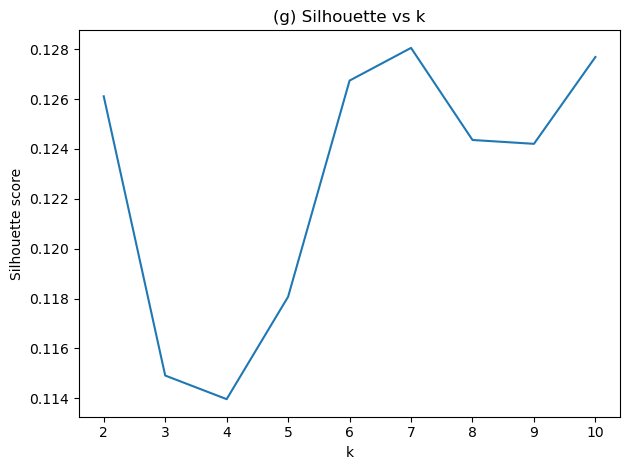

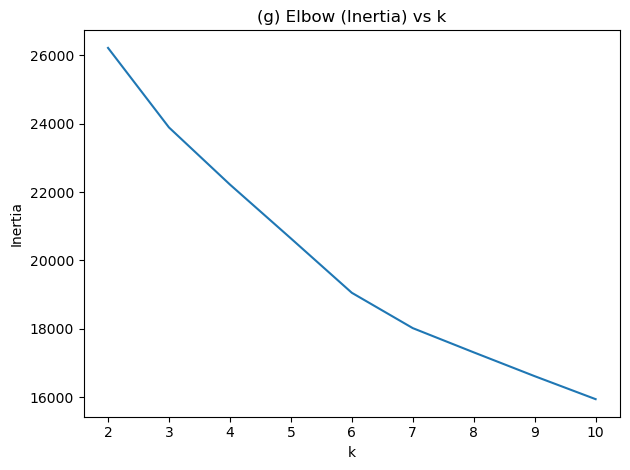


(g) Best k by silhouette: 7


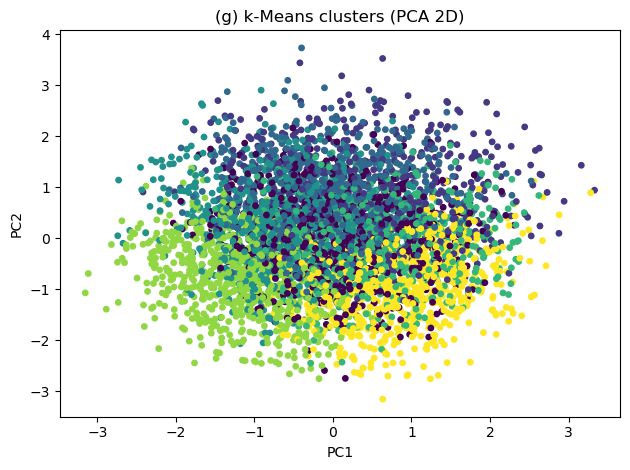


(g) Cluster profile (means):
               Age  Subscription_Length  Support_Tickets_Raised  \
cluster                                                           
0        39.979412            26.144156                1.663636   
1        43.522177            30.483126                4.708703   
2        31.064371            42.661745                1.800000   
3        50.482866            43.696927                1.590782   
4        53.820475            16.193460                1.833787   
5        32.045926            16.199187                1.581301   
6        54.556391            33.130790                1.716621   

         Satisfaction_Score  Discount_Offered  Last_Activity  Count  
cluster                                                              
0                  7.907489         16.339260     102.270130    770  
1                  5.590000         12.810995     168.138544    563  
2                  6.391502         12.032966     279.536913    745  
3               

In [11]:
# k-Means clustering (k selection + PCA visualisation)

# cluster only numeric features (scaled) because k-means uses Euclidean distance.
X_num = df[numeric_cols].copy()
X_scaled = numeric_pipe.fit_transform(X_num)

ks = range(2, 11)
sil_scores = []
inertias = []

# test k from 2 to 10 and store silhouette + inertia
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(km.inertia_)

# Silhouette plot
plt.figure()
plt.plot(list(ks), sil_scores)
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.title("(g) Silhouette vs k")
plt.tight_layout()
plt.show()

# Elbow plot
plt.figure()
plt.plot(list(ks), inertias)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("(g) Elbow (Inertia) vs k")
plt.tight_layout()
plt.show()

# I select the best k based on the highest silhouette score.
best_k = list(ks)[int(np.argmax(sil_scores))]
print("\n(g) Best k by silhouette:", best_k)

km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto")
labels_km = km.fit_predict(X_scaled)

# used PCA to plot the clusters in 2D.
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X2 = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=labels_km, s=15)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("(g) k-Means clusters (PCA 2D)")
plt.tight_layout()
plt.show()

clustered = df[numeric_cols].copy()
clustered["cluster"] = labels_km
profile = clustered.groupby("cluster").mean()
profile["Count"] = clustered["cluster"].value_counts().sort_index().values

print("\n(g) Cluster profile (means):")
print(profile)


(h) Hierarchical silhouette: 0.062370784933961025


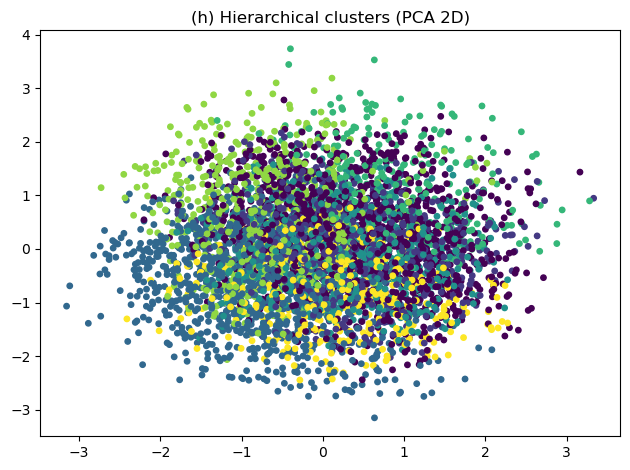


(h) DBSCAN unique labels: [np.int64(-1), np.int64(0), np.int64(1)]
(h) DBSCAN noise ratio: 0.9924


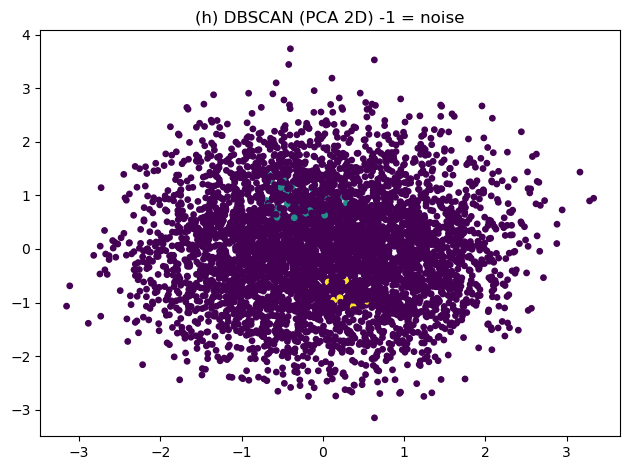

(h) DBSCAN silhouette (excluding noise): 0.6977926783821081
(h) DBSCAN cluster sizes (excluding noise): {0: 28, 1: 10}


In [12]:
# Compare k-Means with Hierarchical + DBSCAN

# Hierarchical clustering with same number of clusters as k-means.
hc = AgglomerativeClustering(n_clusters=best_k)
labels_hc = hc.fit_predict(X_scaled)
sil_hc = silhouette_score(X_scaled, labels_hc)
print("\n(h) Hierarchical silhouette:", sil_hc)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=labels_hc, s=15)
plt.title("(h) Hierarchical clusters (PCA 2D)")
plt.tight_layout()
plt.show()

# DBSCAN clustering
db = DBSCAN(eps=0.7, min_samples=10)
labels_db = db.fit_predict(X_scaled)

unique_labels = sorted(set(labels_db))
noise_ratio = np.mean(labels_db == -1)

print("\n(h) DBSCAN unique labels:", unique_labels)
print("(h) DBSCAN noise ratio:", noise_ratio)

plt.figure()
plt.scatter(X2[:, 0], X2[:, 1], c=labels_db, s=15)
plt.title("(h) DBSCAN (PCA 2D) -1 = noise")
plt.tight_layout()
plt.show()

# Silhouette for DBSCAN is only valid if we have at least 2 clusters excluding noise.
mask = labels_db != -1
if mask.sum() > 0 and len(set(labels_db[mask])) > 1:
    sil_db = silhouette_score(X_scaled[mask], labels_db[mask])
    print("(h) DBSCAN silhouette (excluding noise):", sil_db)
    print("(h) DBSCAN cluster sizes (excluding noise):", pd.Series(labels_db[mask]).value_counts().to_dict())
else:
    print("(h) DBSCAN silhouette not defined (too much noise or only 1 cluster).")